<a href="https://colab.research.google.com/github/avladova/ML-Time-Series/blob/main/%D0%A3%D1%80%D0%BE%D0%BA_3_%D0%9F%D1%80%D0%B5%D0%B4%D0%B8%D0%BA%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D1%82%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек

In [ ]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Настройки отображения
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 6)
%matplotlib inline

In [ ]:
# Параметры генерации
np.random.seed(42)
n_rows = 1000  # Уменьшим размер для примера
km_range = (100, 500)
m_range = (0, 1000)
amplitude_range = (2.0, 25.0)
years = [2019, 2020, 2021, 2022]
months = list(range(1, 13))
days = list(range(1, 29))
otstup_types = ['Просадка', 'Выступ', 'Волна', 'Перекос']
stepeni = [1, 2, 3]

# Генерация данных
data = {
    'КМ': np.random.randint(*km_range, size=n_rows),
    'М': np.random.randint(*m_range, size=n_rows),
    'АМПЛИТУДА': np.round(np.random.uniform(*amplitude_range, size=n_rows), 1),
    'HOPMA': np.full(n_rows, 5),  # Нормативное значение
    'КОДОТСТУП': np.random.randint(1, 5, size=n_rows),
    'ГОД': np.random.choice(years, size=n_rows),
    'МЕСЯЦ': np.random.choice(months, size=n_rows),
    'ДЕНЬ': np.random.choice(days, size=n_rows),
    'СТЕПЕНЬ': np.random.choice(stepeni, size=n_rows, p=[0.6, 0.3, 0.1]),
    'ДЛИНА': np.random.randint(1, 20, size=n_rows),
    'ОТСТУПЛЕНИЕ': np.random.choice(otstup_types, size=n_rows)
}

# Создание DataFrame
df = pd.DataFrame(data)

In [ ]:
    # Создаем временной индекс
df['ДАТА'] = pd.to_datetime(df['ГОД'].astype(str) + '-' +
                               df['МЕСЯЦ'].astype(str) + '-' +
                               df['ДЕНЬ'].astype(str))
df = df.set_index('ДАТА').sort_index()

    # Заполнение пропусков
df['АМПЛИТУДА'] = df['АМПЛИТУДА'].fillna(df['АМПЛИТУДА'].median())

    # Ресемплирование по месяцам
monthly_data = df['АМПЛИТУДА'].resample('ME').mean().to_frame()
monthly_data['ГОД'] = monthly_data.index.year
monthly_data['МЕСЯЦ'] = monthly_data.index.month

df.sample(3)

,КМ,М,АМПЛИТУДА,HOPMA,КОДОТСТУП,ГОД,МЕСЯЦ,ДЕНЬ,СТЕПЕНЬ,ДЛИНА,ОТСТУПЛЕНИЕ
ДАТА,,,,,,,,,,,
2020-10-12,393,833,7.8,5,3,2020,10,12,1,14,Волна
2019-06-04,379,954,14.0,5,4,2019,6,4,2,11,Перекос
2021-11-12,242,423,16.7,5,1,2021,11,12,3,13,Просадка


Разница между описательной и предиктивной аналитикой:
Описательная аналитика отвечает на вопрос "Что произошло?" - анализ исторических данных
Предиктивная аналитика отвечает на вопрос "Что может произойти?" - прогнозирование будущих значений

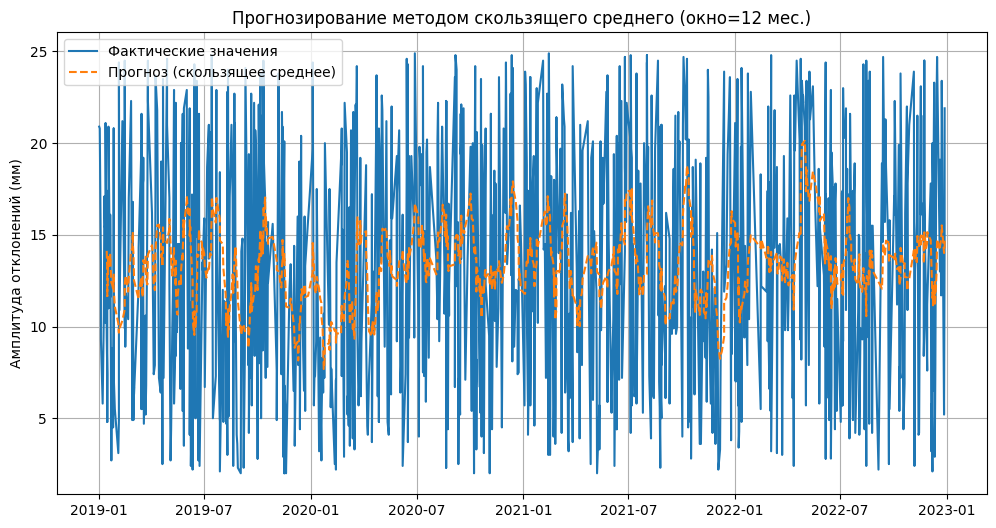

In [ ]:
# 2. Скользящие средние (простая модель прогнозирования)
def moving_average_forecast(data, window_size=12):
    """Прогнозирование с помощью скользящего среднего"""
    forecast = df['АМПЛИТУДА'].rolling(window=window_size).mean()

    plt.plot(df['АМПЛИТУДА'], label='Фактические значения')
    plt.plot(forecast, label='Прогноз (скользящее среднее)', linestyle='--')
    plt.title(f'Прогнозирование методом скользящего среднего (окно={window_size} мес.)')
    plt.ylabel('Амплитуда отклонений (мм)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast

ma_forecast = moving_average_forecast(data)

Скользящее среднее сглаживает временной ряд
Чем больше окно, тем более сглаженный прогноз
Не учитывает тренд и сезонность
Простая базовая модель для сравнения с более сложными

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

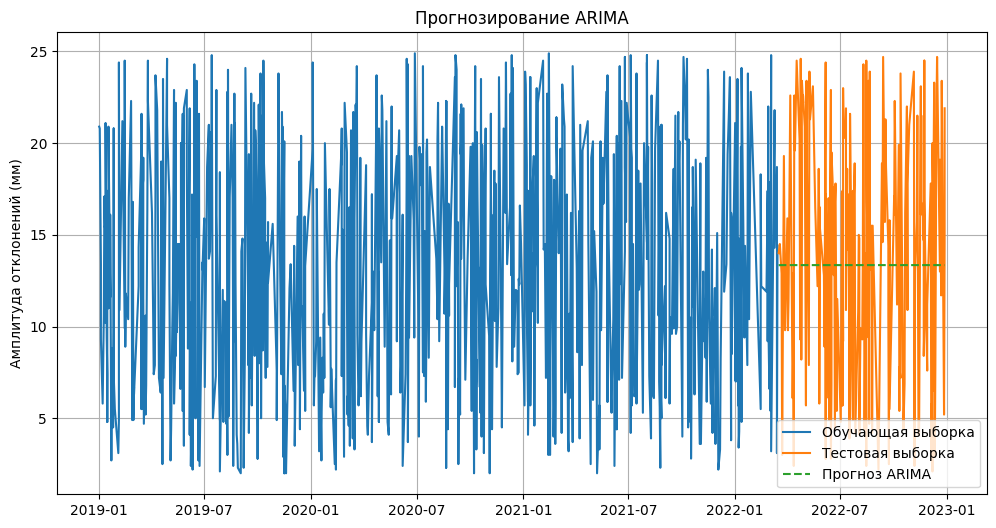

Средняя абсолютная ошибка (MAE): 5.70 мм


In [ ]:
# 3. ARIMA модель (авторегрессия + интегрирование + скользящее среднее)
def arima_forecast(data):
    """Прогнозирование с помощью ARIMA"""
    # Разделение на обучающую и тестовую выборки
    train_size = int(len(data) * 0.8)
    train, test = data.iloc[:train_size], data.iloc[train_size:]

    # Подбор параметров ARIMA (p,d,q)
    model = ARIMA(train['АМПЛИТУДА'], order=(1,1,1))
    model_fit = model.fit()

    # Прогнозирование
    forecast = model_fit.forecast(steps=len(test))

    # Визуализация
    plt.plot(train['АМПЛИТУДА'], label='Обучающая выборка')
    plt.plot(test['АМПЛИТУДА'], label='Тестовая выборка')
    plt.plot(test.index, forecast, label='Прогноз ARIMA', linestyle='--')
    plt.title('Прогнозирование ARIMA')
    plt.ylabel('Амплитуда отклонений (мм)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Оценка точности
    mae = mean_absolute_error(test['АМПЛИТУДА'], forecast)
    print(f'Средняя абсолютная ошибка (MAE): {mae:.2f} мм')

    return model_fit

arima_model = arima_forecast(df)

ARIMA (AutoRegressive Integrated Moving Average) - линейная модель
Параметры:
   - p: порядок авторегрессии (зависимость от предыдущих значений)
   - d: порядок дифференцирования (устранение нестационарности)
   - q: порядок скользящего среднего
Преимущества: простота интерпретации, хорошая точность для стационарных рядов
Недостатки: не учитывает сложные нелинейные зависимости

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


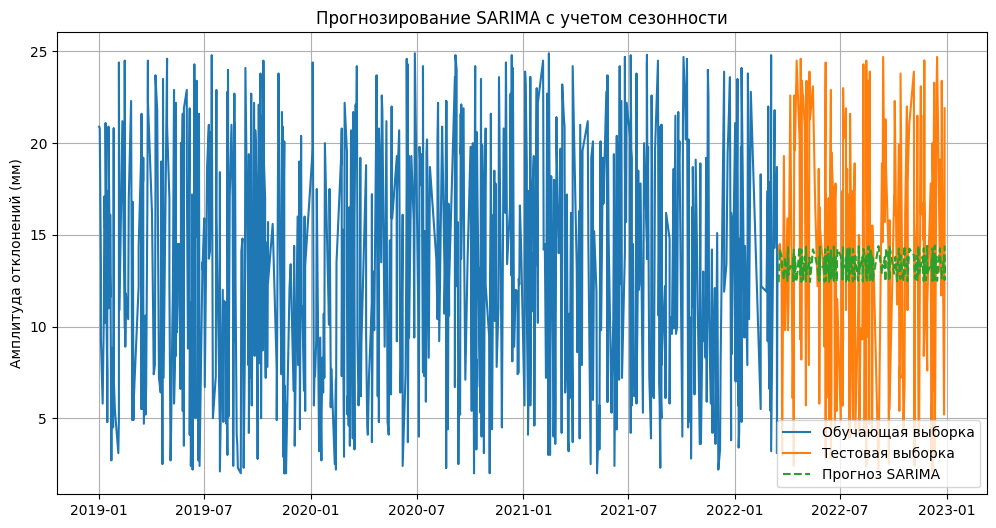

Средняя абсолютная ошибка (MAE): 5.71 мм


In [ ]:
# 4. SARIMA модель (сезонная ARIMA)
def sarima_forecast(data):
    """Прогнозирование с учетом сезонности (SARIMA)"""
    train_size = int(len(data) * 0.8)
    train, test = data.iloc[:train_size], data.iloc[train_size:]

    # Параметры: (p,d,q)(P,D,Q,s) где s=12 (годовая сезонность)
    model = SARIMAX(train['АМПЛИТУДА'],
                   order=(1,1,1),
                   seasonal_order=(1,1,1,12))
    model_fit = model.fit(disp=False)

    # Прогнозирование
    forecast = model_fit.forecast(steps=len(test))

    # Визуализация
    plt.plot(train['АМПЛИТУДА'], label='Обучающая выборка')
    plt.plot(test['АМПЛИТУДА'], label='Тестовая выборка')
    plt.plot(test.index, forecast, label='Прогноз SARIMA', linestyle='--')
    plt.title('Прогнозирование SARIMA с учетом сезонности')
    plt.ylabel('Амплитуда отклонений (мм)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Оценка точности
    mae = mean_absolute_error(test['АМПЛИТУДА'], forecast)
    print(f'Средняя абсолютная ошибка (MAE): {mae:.2f} мм')

    return model_fit

sarima_model = sarima_forecast(df)

SARIMA учитывает сезонные паттерны
Дополнительные параметры для сезонной компоненты
Лучше подходит для данных с выраженной сезонностью
Более точные прогнозы по сравнению с ARIMA

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


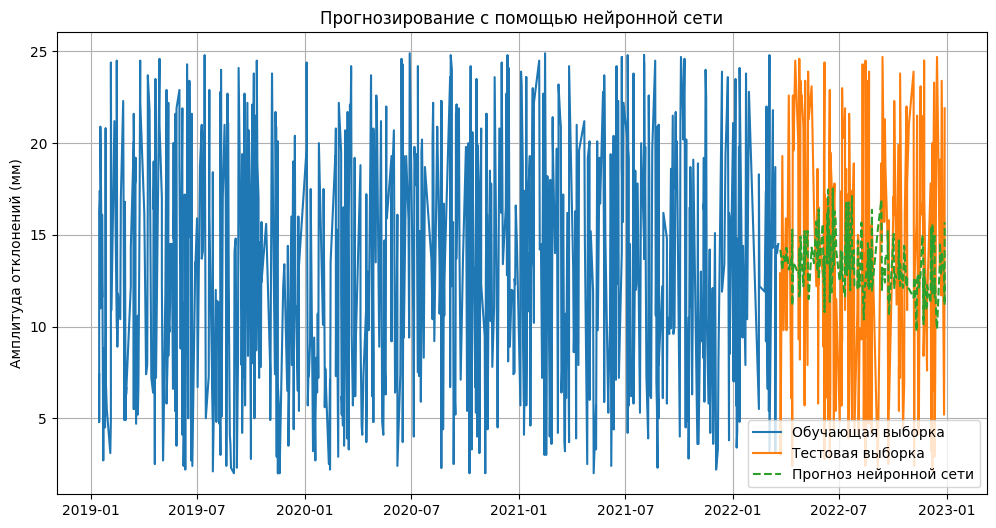

Средняя абсолютная ошибка (MAE): 5.93 мм


In [ ]:
# 5. Нейронные сети для прогнозирования
def nn_forecast(data):
    """Прогнозирование с помощью нейронной сети"""
    # Создание признаков
    data['LAG_1'] = data['АМПЛИТУДА'].shift(1)
    data['LAG_12'] = data['АМПЛИТУДА'].shift(12)
    data = data.dropna()

    # Разделение на признаки и целевую переменную
    X = data[['LAG_1', 'LAG_12', 'МЕСЯЦ']]
    y = data['АМПЛИТУДА']

    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False)

    # Масштабирование данных
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Создание и обучение модели
    model = MLPRegressor(hidden_layer_sizes=(50, 50),
                        activation='relu',
                        max_iter=1000,
                        random_state=42)
    model.fit(X_train_scaled, y_train)

    # Прогнозирование
    forecast = model.predict(X_test_scaled)

    # Визуализация
    plt.plot(y_train.index, y_train, label='Обучающая выборка')
    plt.plot(y_test.index, y_test, label='Тестовая выборка')
    plt.plot(y_test.index, forecast, label='Прогноз нейронной сети', linestyle='--')
    plt.title('Прогнозирование с помощью нейронной сети')
    plt.ylabel('Амплитуда отклонений (мм)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Оценка точности
    mae = mean_absolute_error(y_test, forecast)
    print(f'Средняя абсолютная ошибка (MAE): {mae:.2f} мм')

    return model

nn_model = nn_forecast(df)

Нейронные сети могут выявлять сложные нелинейные зависимости
Требуется тщательная подготовка данных и подбор архитектуры
Преимущества: гибкость, возможность учета сложных паттернов
Недостатки: "черный ящик", требует больше данных для обучения

In [ ]:
df
#неправильно кодирует ОТСТУПЛЕНИЕ КОДОТСТУПом

,КМ,М,АМПЛИТУДА,HOPMA,КОДОТСТУП,ГОД,МЕСЯЦ,ДЕНЬ,СТЕПЕНЬ,ДЛИНА,ОТСТУПЛЕНИЕ,LAG_1,LAG_12,LAG_2,LAG_3,LAG_24
ДАТА,,,,,,,,,,,,,,,,
2019-01-01,148,601,20.9,5,2,2019,1,1,1,18,Перекос,NaN,NaN,NaN,NaN,NaN
2019-01-02,249,677,20.8,5,3,2019,1,2,1,10,Выступ,20.9,NaN,NaN,NaN,NaN
2019-01-04,325,570,13.4,5,2,2019,1,4,1,18,Выступ,20.8,NaN,20.9,NaN,NaN
2019-01-04,388,725,9.3,5,3,2019,1,4,2,15,Перекос,13.4,NaN,20.8,20.9,NaN
2019-01-07,197,244,5.8,5,4,2019,1,7,1,6,Выступ,9.3,NaN,13.4,20.8,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-22,374,760,11.7,5,2,2022,12,22,2,3,Выступ,19.1,6.5,13.0,24.7,9.9
2022-12-23,276,370,23.4,5,1,2022,12,23,2,3,Просадка,11.7,14.7,19.1,13.0,24.5
2022-12-27,317,708,5.2,5,4,2022,12,27,1,7,Просадка,23.4,23.3,11.7,19.1,17.0


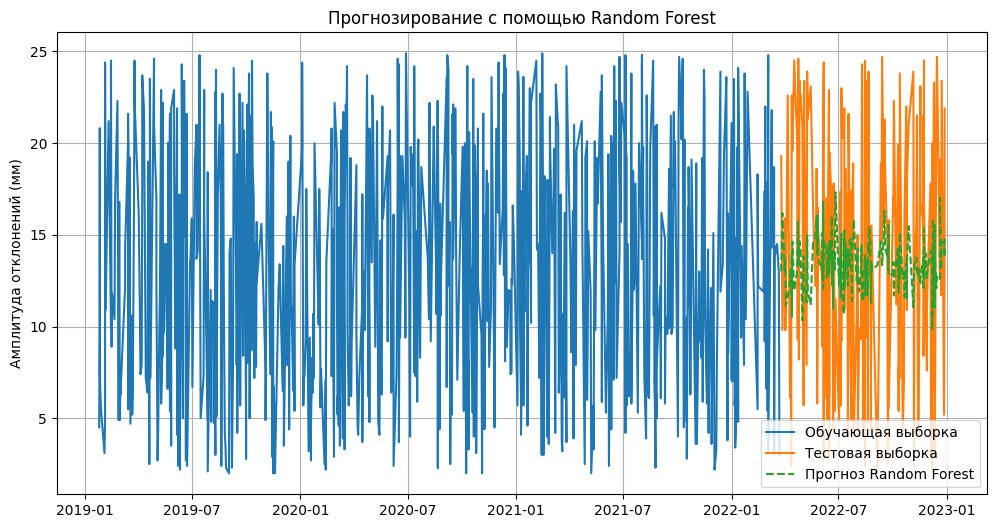

Средняя абсолютная ошибка (MAE): 5.69 мм


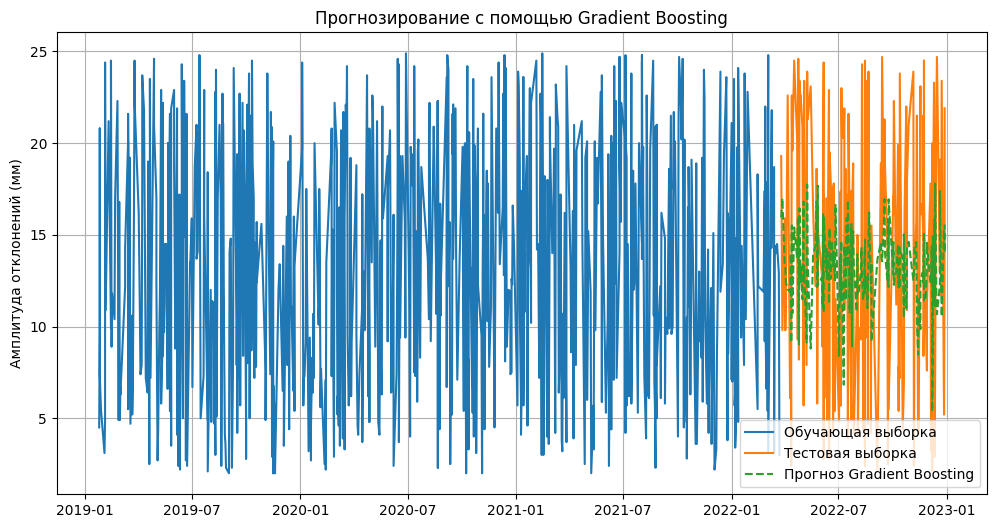

Средняя абсолютная ошибка (MAE): 5.82 мм


In [ ]:
# 6. Модели на основе деревьев решений
def tree_based_forecast(data, model_type='rf'):
    """Прогнозирование с помощью Random Forest или Gradient Boosting"""
    # Создание признаков
    for i in [1, 2, 3, 12, 24]:
        data[f'LAG_{i}'] = data['АМПЛИТУДА'].shift(i)
    data = data.dropna()

    # Разделение на признаки и целевую переменную
    X = data.drop(columns=['АМПЛИТУДА', 'ОТСТУПЛЕНИЕ'])
    y = data['АМПЛИТУДА']

    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=False)

    # Выбор модели
    if model_type == 'rf':
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model_name = 'Random Forest'
    else:
        model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        model_name = 'Gradient Boosting'

    # Обучение модели
    model.fit(X_train, y_train)

    # Прогнозирование
    forecast = model.predict(X_test)

    # Визуализация
    plt.plot(y_train.index, y_train, label='Обучающая выборка')
    plt.plot(y_test.index, y_test, label='Тестовая выборка')
    plt.plot(y_test.index, forecast, label=f'Прогноз {model_name}', linestyle='--')
    plt.title(f'Прогнозирование с помощью {model_name}')
    plt.ylabel('Амплитуда отклонений (мм)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Оценка точности
    mae = mean_absolute_error(y_test, forecast)
    print(f'Средняя абсолютная ошибка (MAE): {mae:.2f} мм')

    return model

rf_model = tree_based_forecast(df, 'rf')
gb_model = tree_based_forecast(df, 'gb')

1. Random Forest:
   - Ансамбль многих деревьев решений
   - Устойчив к переобучению
   - Хорошо работает с категориальными признаками

2. Gradient Boosting:
   - Последовательное построение деревьев
   - Часто дает более точные прогнозы
   - Более чувствителен к настройкам

3. Общие преимущества:
   - Не требуют предположений о распределении данных
   - Могут учитывать сложные взаимодействия признаков

4. Недостатки:
   - Менее интерпретируемы, чем линейные модели
   - Требуют тщательной подготовки признаков

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


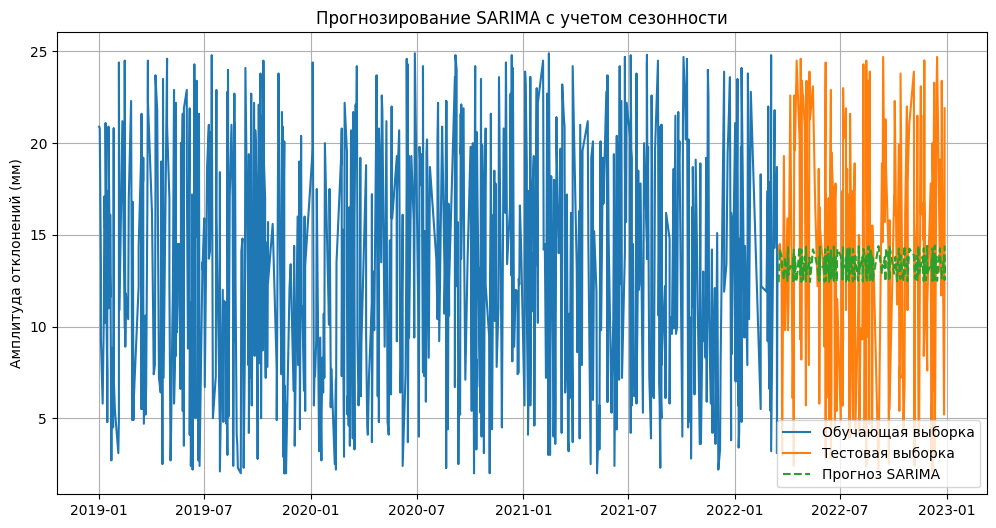

Средняя абсолютная ошибка (MAE): 5.71 мм


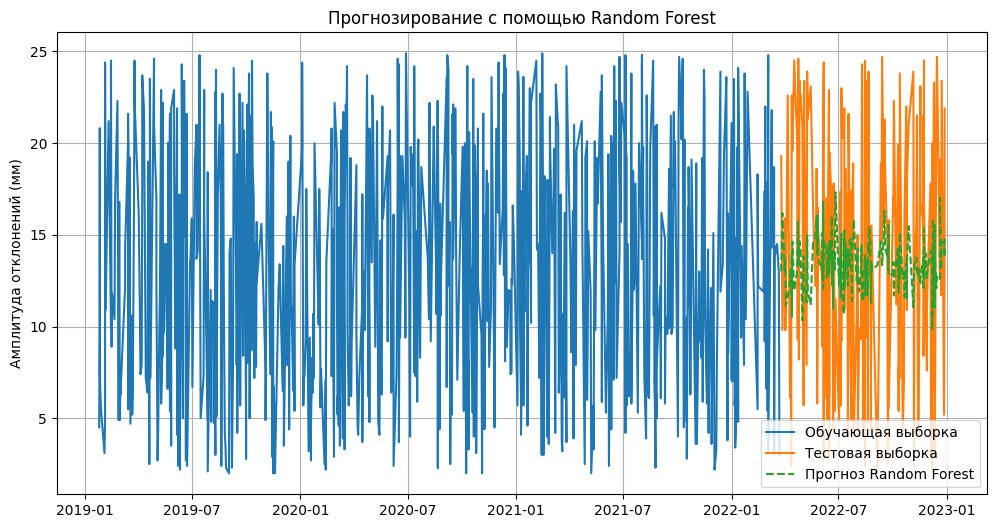

Средняя абсолютная ошибка (MAE): 5.69 мм


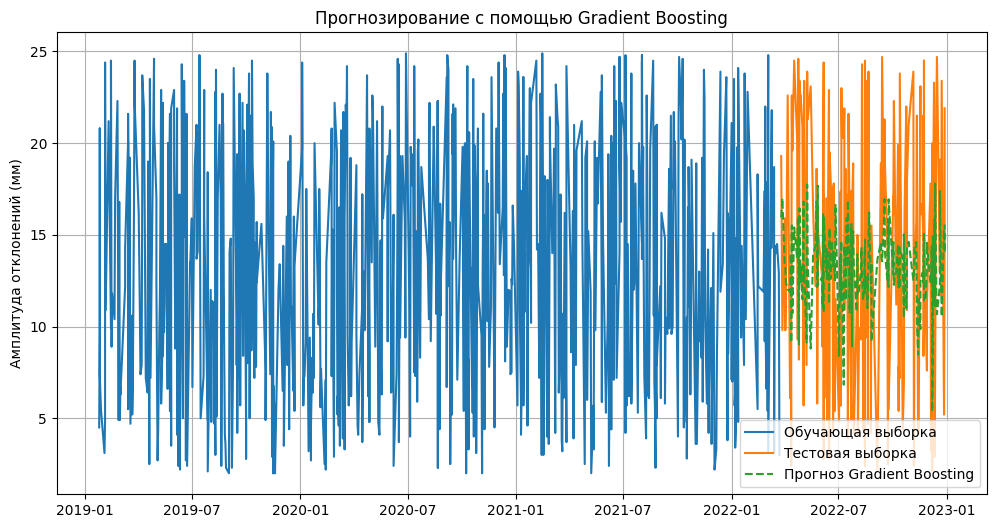

Средняя абсолютная ошибка (MAE): 5.82 мм


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


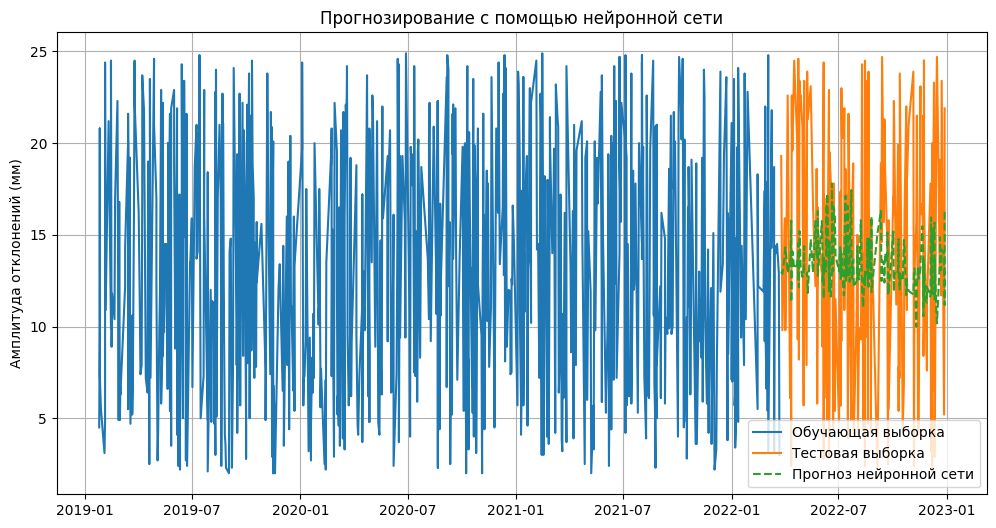

Средняя абсолютная ошибка (MAE): 5.89 мм


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
# 7. Сравнение моделей
def compare_models(data):
    """Сравнение точности разных моделей"""
    models = {
        'SARIMA': sarima_forecast(data),
        'Random Forest': tree_based_forecast(data, 'rf'),
        'Gradient Boosting': tree_based_forecast(data, 'gb'),
        'Нейронная сеть': nn_forecast(data)
    }

    # Сравнение метрик (можно добавить другие метрики)
    comparison = pd.DataFrame({
        'Модель': list(models.keys()),
        'MAE': [mean_absolute_error(
            data.iloc[int(len(data)*0.8):]['АМПЛИТУДА'],
            model.predict(data.iloc[int(len(data)*0.8):]))
            for model in models.values()]
    })

    print("\nСравнение моделей:")
    print(comparison.sort_values('MAE'))

    return comparison

model_comparison = compare_models(df)

Разные подходы к прогнозированию имеют свои преимущества и недостатки
Для временных рядов с сезонностью SARIMA часто показывает хорошие результаты
Методы машинного обучения требуют больше подготовки данных, но могут выявлять сложные зависимости
Выбор модели зависит от:
   - Точности прогноза
   - Интерпретируемости результатов
   - Вычислительных ресурсов
   - Требований к скорости прогнозирования